<a href="https://colab.research.google.com/github/wizard339/education/blob/main/w2v_tfidf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
import gensim
import gensim.downloader
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

Данные взяты отсюда:
https://www.kaggle.com/datasets/cclark/product-item-data

In [3]:
data = pd.read_csv('sample-data.csv')
data.head()

,id,description
0,1,Active classic boxers - There's a reason why o...
1,2,Active sport boxer briefs - Skinning up Glory ...
2,3,Active sport briefs - These superbreathable no...
3,4,"Alpine guide pants - Skin in, climb ice, switc..."
4,5,"Alpine wind jkt - On high ridges, steep ice an..."


Создаем матрицу эмбеддингов с помощью TfidfVectorizer

In [4]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_embeddings = tfidf.fit_transform(data.description).toarray()
tfidf_embeddings.shape

(500, 4600)

In [61]:
print(data.description.iloc[101])
print(data.description.iloc[3])

Planer t-shirt - The Planer T-Shirt gives a nod to the surfing working man, with original Patagonia studio artwork for Fletcher Chouinard Designs. Made of 100% organic cotton, the shirt sports the same graphic on front pocket and back of tee, printed with inks that are PVC- and phthalate-free. Ringspun yarns and taped shoulder seams lend a soft touch. Doublestitching at sleeves and hem; coverstitched at neck and armholes for a clean finish. The tee is recyclable through the Common Threads Recycling Program.<br><br><b>Details:</b><ul> <li>Ringspun yarns for a softer hand</li> <li>Taped shoulder seams</li> <li>Screen-print inks are PVC- and phthalate-free</li></ul><br><br><b>Fabric: </b>5.4-oz 100% organic cotton. Recyclable through the Common Threads Recycling Program<br><br><b>Weight: </b>(175 g 6.1 oz)<br><br>Made in USA.
Alpine guide pants - Skin in, climb ice, switch to rock, traverse a knife-edge ridge and boogie back down - these durable, weather-resistant and breathable soft-shel

Функция выводящая список индексов наиболее похожих описаний товаров.
На вход подается индекс товара, для которого хотим сформировать рекоммендации, а также матрицу эмбеддингов (для описаний товаров) и порог (treshold), по которому отсекаем описания товаров по попарному косинусному сходству (sklearn.metrics.pairwise.cosine_similarity).

In [45]:
def similar_ids(id: int, emb_matrix: np.ndarray, treshold: float=0.4) -> list:
  cos_sim_matrix = cosine_similarity(emb_matrix, emb_matrix)
  id_cos_similaraties = enumerate(cos_sim_matrix[id])
  similar_ids = [i for i, s in id_cos_similaraties if s >= treshold]
  return similar_ids

Выводим список доступных предобученных моделей в модуле gensim. Нас интересует модель word2vec для английского языка.

Загружаем word2vec-google-news-300

In [62]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [63]:
w2v_embeddings = gensim.downloader.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


Формируем матрицу эмбеддингов для текстов описаний товаров.

Приводим текст к нижнему регистру, производим удаление html-тегов.

Стоп-слова не учитываем.

Эмбеддинг слов берем из словаря предобученной модели word2vec, которую мы загрузили ранее. Затем формируем эмбеддинг для каждого текста путем усреднения эмбеддингов, входящих в текст слов.


In [108]:
nltk.download('stopwords')
docs_vectors = pd.DataFrame()
stopwords = nltk.corpus.stopwords.words('english')
for doc in data.description.str.lower().str.replace('<*[a-z]>', ''):
  temp = pd.DataFrame()
  for word in doc.split(' '):
    if word not in stopwords:
      try:
        word_vec = w2v_embeddings[word]
        temp = temp.append(pd.Series(word_vec), ignore_index=True)
      except:
        pass
  doc_vector = temp.mean()
  docs_vectors = docs_vectors.append(doc_vector, ignore_index=True)
docs_vectors.shape

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-108-effa7d5f9de8>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  for doc in data.description.str.lower().str.replace('<*[a-z]>', ''):


(500, 300)

Построим гистограмму распределения количества похожих товаров при использоввании косинусного сходства, матрицы эмбеддингов на основе word2vec и заданного treshold.

(array([260.,  92.,  40.,  52.,  28.,  10.,  11.,   3.,   2.,   2.]),
 array([ 1. ,  5.5, 10. , 14.5, 19. , 23.5, 28. , 32.5, 37. , 41.5, 46. ]),
 <a list of 10 Patch objects>)

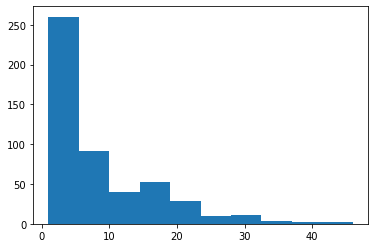

In [113]:
plt.hist([len(similar_ids(i, docs_vectors, treshold=0.92)) for i in range(data.shape[0])])

В данном случае (при пороге 0.92) значительная часть товаров имеет до 20 аналогичных товаров, которые можно попробовать предложить в рекоммендации.